In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# 5 secs of data (20 * 5)
SEQ_LEN = 100 
FEATURE_LEN = 6
COLUMNS = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label']

In [4]:
har_df = pd.read_csv('data/har.csv')

In [5]:
label_encoder = LabelEncoder()
har_df['label'] = label_encoder.fit_transform(har_df.activity)

In [6]:
min_max_scaler = MinMaxScaler()

har_df[COLUMNS[:-1]] = min_max_scaler.fit_transform(har_df[COLUMNS[:-1]])

In [7]:
har_df.head()

,subject_id,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
0,1600,walking,90426757696641,0.669476,0.727162,0.608499,0.504596,0.491203,0.646411,16
1,1600,walking,90426807196641,0.651024,0.726768,0.602062,0.505633,0.497057,0.651338,16
2,1600,walking,90426856696641,0.646167,0.727190,0.600859,0.501102,0.502988,0.648563,16
3,1600,walking,90426906196641,0.656575,0.716657,0.619803,0.500629,0.509722,0.649307,16
4,1600,walking,90426955696641,0.666135,0.731021,0.641155,0.501132,0.516456,0.652243,16


In [8]:
train_df, test_df = train_test_split(har_df, train_size = .9, random_state=42, shuffle=False)
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
train_df.shape, test_df.shape

((2856541, 11), (317394, 11))

In [10]:
train_df.head(50)

,index,subject_id,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
0,0,1600,walking,90426757696641,0.669476,0.727162,0.608499,0.504596,0.491203,0.646411,16
1,1,1600,walking,90426807196641,0.651024,0.726768,0.602062,0.505633,0.497057,0.651338,16
2,2,1600,walking,90426856696641,0.646167,0.727190,0.600859,0.501102,0.502988,0.648563,16
3,3,1600,walking,90426906196641,0.656575,0.716657,0.619803,0.500629,0.509722,0.649307,16
4,4,1600,walking,90426955696641,0.666135,0.731021,0.641155,0.501132,0.516456,0.652243,16
5,5,1600,walking,90427005196641,0.682069,0.738822,0.655573,0.498630,0.521723,0.649729,16
6,6,1600,walking,90427054696641,0.694019,0.719699,0.660832,0.490376,0.523082,0.648261,16
7,7,1600,walking,90427104196641,0.695047,0.699195,0.660492,0.497745,0.520812,0.657995,16
8,8,1600,walking,90427153696641,0.694662,0.697252,0.660570,0.505999,0.520379,0.671047,16
9,9,1600,walking,90427203196641,0.697129,0.689310,0.637073,0.504184,0.517429,0.674547,16


In [24]:
import itertools
from scipy import stats

def prepare_dataset(df):
    global SEQ_LEN, COLUMNS
    
    X = []
    y = []
    
    for i in range(0, len(df), SEQ_LEN):
        features = df.loc[i:i+SEQ_LEN-1, COLUMNS[:-1]].values
        label = stats.mode(df.loc[i:i+SEQ_LEN-1, COLUMNS[-1]].values)[0][0]
        
        if len(features) != SEQ_LEN:
            continue
        
        X.append(features.reshape(-1, SEQ_LEN, len(COLUMNS[:-1])))
        y.append(label)
        
    return np.concatenate(X), np.asarray(y)

In [25]:
X_train, y_train = prepare_dataset(train_df)

display(X_train.shape)
display(y_train.shape)

(28565, 100, 6)

(28565,)

In [26]:
X_train[0, :180, 0]

array([0.66947634, 0.65102411, 0.64616691, 0.6565752 , 0.66613541,
       0.68206909, 0.69401935, 0.69504732, 0.69466183, 0.69712898,
       0.67333126, 0.66366826, 0.65269458, 0.64968774, 0.66909085,
       0.74135779, 0.77240277, 0.8051953 , 0.8202295 , 0.78543241,
       0.74716587, 0.69820836, 0.68993313, 0.68363675, 0.71021002,
       0.75276837, 0.77119489, 0.80586349, 0.7804981 , 0.82821563,
       0.82220837, 0.73819675, 0.71100671, 0.67872815, 0.69317126,
       0.71321686, 0.69825976, 0.72658059, 0.75181748, 0.75749706,
       0.76207158, 0.75140629, 0.73968733, 0.74392774, 0.76322805,
       0.7560065 , 0.77628339, 0.80167448, 0.78933872, 0.82811926,
       0.8109263 , 0.72717168, 0.70859095, 0.70512152, 0.70602101,
       0.70095821, 0.691141  , 0.72344526, 0.74791116, 0.78391614,
       0.78638328, 0.7409723 , 0.76006702, 0.74462163, 0.76703158,
       0.75215158, 0.80498971, 0.78496982, 0.82711697, 0.82161728,
       0.76307385, 0.73141209, 0.72879074, 0.71527281, 0.71365

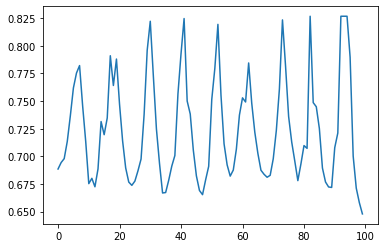

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(X_train[100, :1080, 0])), X_train[100, :1080, 0])

In [28]:
test_df.head()

,index,subject_id,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
0,2856541,1646,stairs,1469101057176660,0.679727,0.722621,0.555002,0.493594,0.493697,0.631541,12
1,2856542,1646,stairs,1469101107162550,0.698025,0.726761,0.550711,0.487202,0.479472,0.626091,12
2,2856543,1646,stairs,1469101157148440,0.722517,0.713636,0.541684,0.490055,0.472784,0.622531,12
3,2856544,1646,stairs,1469101207134330,0.753639,0.657956,0.572822,0.516388,0.480275,0.626594,12
4,2856545,1646,stairs,1469101257120220,0.765846,0.615372,0.643758,0.514069,0.500663,0.666395,12


In [29]:
X_test, y_test = prepare_dataset(test_df)

In [30]:
X_test.shape, y_test.shape

((3173, 100, 6), (3173,))

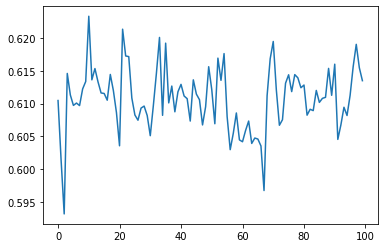

In [31]:
plt.plot(range(0, len(X_test[100, :1080, 0])), X_test[100, :1080, 0])

In [32]:
from numpy import save

save('data/X_train.npy', X_train)
save('data/y_train.npy', y_train)
save('data/X_test', X_test)
save('data/y_test', y_test)